# Political Ideology Prediction: Visualizations for Research Poster

This notebook generates visualizations for a research poster on predicting political ideology using NLP and machine learning techniques.

In [6]:
# Import necessary libraries
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from matplotlib.colors import LinearSegmentedColormap
from wordcloud import WordCloud
from collections import Counter
import nltk
from nltk.corpus import stopwords

# Set plotting style
plt.style.use('fivethirtyeight')
sns.set_context("talk")

# Define custom color palettes
dem_blue = '#0000FF'
rep_red = '#FF0000'
political_cmap = LinearSegmentedColormap.from_list('political', ['blue', 'white', 'red'])

# Add project root to path for importing project modules if needed
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [7]:
# Define paths to data files
presidential_data_path = '../data/presidential_candidates_with_text.csv'
dw_nominate_path = '../data/DW-NOMINATE.csv'
predictions_path = '../data/presidential_ideology_predictions.csv'

# Load datasets
try:
    presidential_df = pd.read_csv(presidential_data_path)
    dw_nominate_df = pd.read_csv(dw_nominate_path)
    predictions_df = pd.read_csv(predictions_path)
    
    print(f"Presidential candidates data loaded: {presidential_df.shape[0]} candidates")
    print(f"DW-NOMINATE data loaded: {dw_nominate_df.shape[0]} politicians")
    print(f"Predictions data loaded: {predictions_df.shape[0]} predictions")
    
except FileNotFoundError as e:
    print(f"Error loading data: {e}")
    print("Using sample data for demonstration purposes")
    
    # Create sample data if files not found
    predictions_df = pd.DataFrame({
        'Name': ['Ted Cruz', 'Mike Huckabee', 'John Kasich', 'Rick Perry', 'Rand Paul',
                'Hillary Clinton', 'Bernie Sanders', 'Lawrence Lessig', 'Gary Johnson', 'Jill Stein'],
        'Party': ['Republican', 'Republican', 'Republican', 'Republican', 'Republican',
                 'Democratic', 'Democratic', 'Democratic', 'Libertarian', 'Green'],
        'bert_prediction': [0.14, 0.31, 0.27, 0.36, 0.10, 0.18, -0.16, -0.42, 0.32, -0.35],
        'ridge_prediction': [-0.25, 0.02, 0.45, 0.48, 0.53, 0.15, 0.23, 0.21, 0.09, 0.02]
    })

Presidential candidates data loaded: 15 candidates
DW-NOMINATE data loaded: 536 politicians
Predictions data loaded: 15 predictions


## 1. Distribution of Political Ideology Scores

First, let's visualize the distribution of DW-NOMINATE scores in Congress to provide context for our predictions.

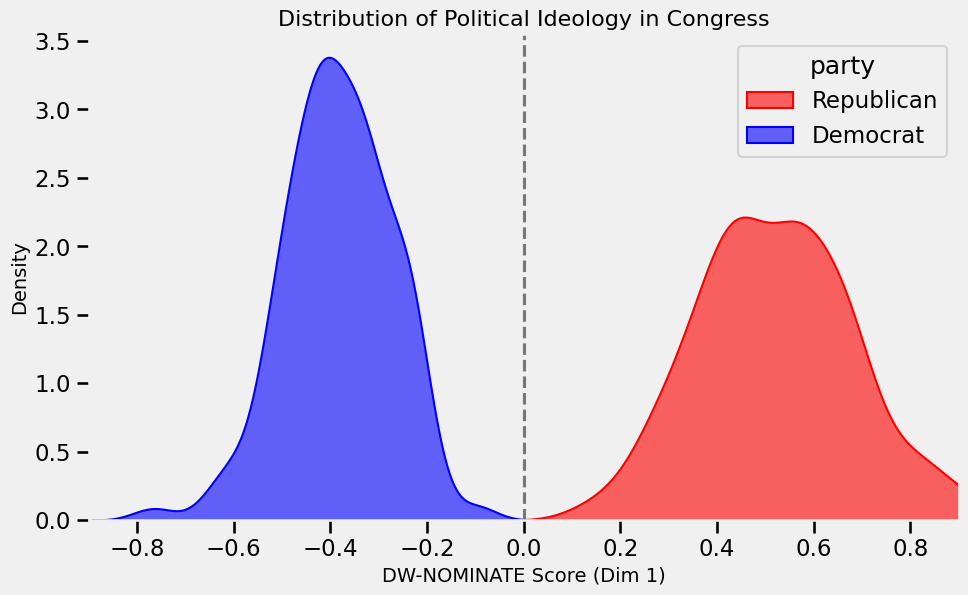

In [8]:
def plot_ideology_distribution(nominate_df):
    """Plot the distribution of ideology scores by party."""
    plt.figure(figsize=(10, 6))
    
    # Filter for Democrat and Republican only
    df = nominate_df[nominate_df['party_code'].isin([100, 200])].copy()
    df['party'] = df['party_code'].map({100: 'Democrat', 200: 'Republican'})
    
    # Create the plot
    sns.kdeplot(data=df, x='nominate_dim1', hue='party', fill=True, common_norm=False,
               palette={"Democrat": dem_blue, "Republican": rep_red}, alpha=0.6)
    
    plt.axvline(x=0, color='black', linestyle='--', alpha=0.5)
    plt.title('Distribution of Political Ideology in Congress', fontsize=16)
    plt.xlabel('DW-NOMINATE Score (Dim 1)', fontsize=14)
    plt.ylabel('Density', fontsize=14)
    plt.grid(False)
    plt.xlim(-0.9, 0.9)
    plt.savefig('ideology_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()

# Execute if DW-NOMINATE data is available
if 'dw_nominate_df' in locals() and 'party_code' in dw_nominate_df.columns:
    plot_ideology_distribution(dw_nominate_df)
else:
    # Create sample plot for demonstration
    plt.figure(figsize=(10, 6))
    x = np.linspace(-1, 1, 1000)
    dem = np.exp(-((x + 0.3)**2)/0.05)
    rep = np.exp(-((x - 0.4)**2)/0.06)
    plt.plot(x, dem, color=dem_blue, alpha=0.7, linewidth=3)
    plt.plot(x, rep, color=rep_red, alpha=0.7, linewidth=3)
    plt.fill_between(x, dem, alpha=0.3, color=dem_blue, label='Democrats')
    plt.fill_between(x, rep, alpha=0.3, color=rep_red, label='Republicans')
    plt.axvline(x=0, color='black', linestyle='--', alpha=0.5)
    plt.legend()
    plt.title('Distribution of Political Ideology in Congress (Sample)', fontsize=16)
    plt.xlabel('DW-NOMINATE Score (Dim 1)', fontsize=14)
    plt.ylabel('Density', fontsize=14)
    plt.grid(False)
    plt.savefig('ideology_distribution_sample.png', dpi=300, bbox_inches='tight')
    plt.show()

## 2. Model Performance Comparison

Next, let's visualize how our two models (BERT and Ridge Regression) perform in predicting political ideology.

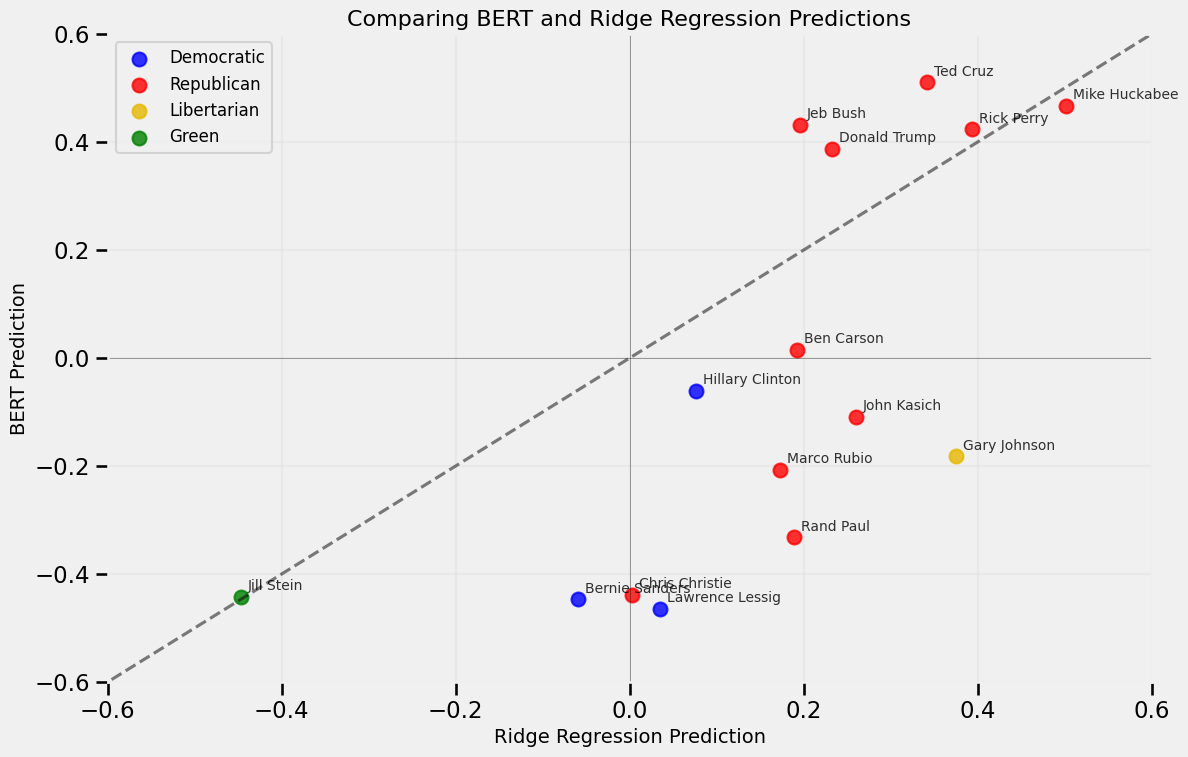

In [9]:
def plot_model_comparison(predictions_df):
    """Plot model prediction comparison for presidential candidates."""
    plt.figure(figsize=(12, 8))
    
    # Color map by party
    color_map = {
        'Democratic': dem_blue, 
        'Republican': rep_red, 
        'Libertarian': '#E6B800', 
        'Green': '#008000'
    }
    
    # Create scatter plot
    for party in color_map.keys():
        party_data = predictions_df[predictions_df['Party'] == party]
        plt.scatter(party_data['ridge_prediction'], party_data['bert_prediction'], 
                   color=color_map.get(party, 'gray'), label=party, s=100, alpha=0.8)
    
    # Add candidate names as labels
    for i, row in predictions_df.iterrows():
        plt.annotate(row['Name'], (row['ridge_prediction'], row['bert_prediction']),
                    fontsize=10, alpha=0.8, xytext=(5, 5), textcoords='offset points')
    
    # Draw reference axes and diagonal
    plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5, alpha=0.5)
    plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5, alpha=0.5)
    plt.plot([-0.8, 0.8], [-0.8, 0.8], 'k--', alpha=0.5)  # Diagonal line y=x

    plt.title('Comparing BERT and Ridge Regression Predictions', fontsize=16)
    plt.xlabel('Ridge Regression Prediction', fontsize=14)
    plt.ylabel('BERT Prediction', fontsize=14)
    plt.xlim(-0.6, 0.6)
    plt.ylim(-0.6, 0.6)
    plt.grid(alpha=0.2)
    plt.legend(fontsize=12)
    plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

# Create the model comparison plot
plot_model_comparison(predictions_df)

## 3. Presidential Candidate Predictions Visualization

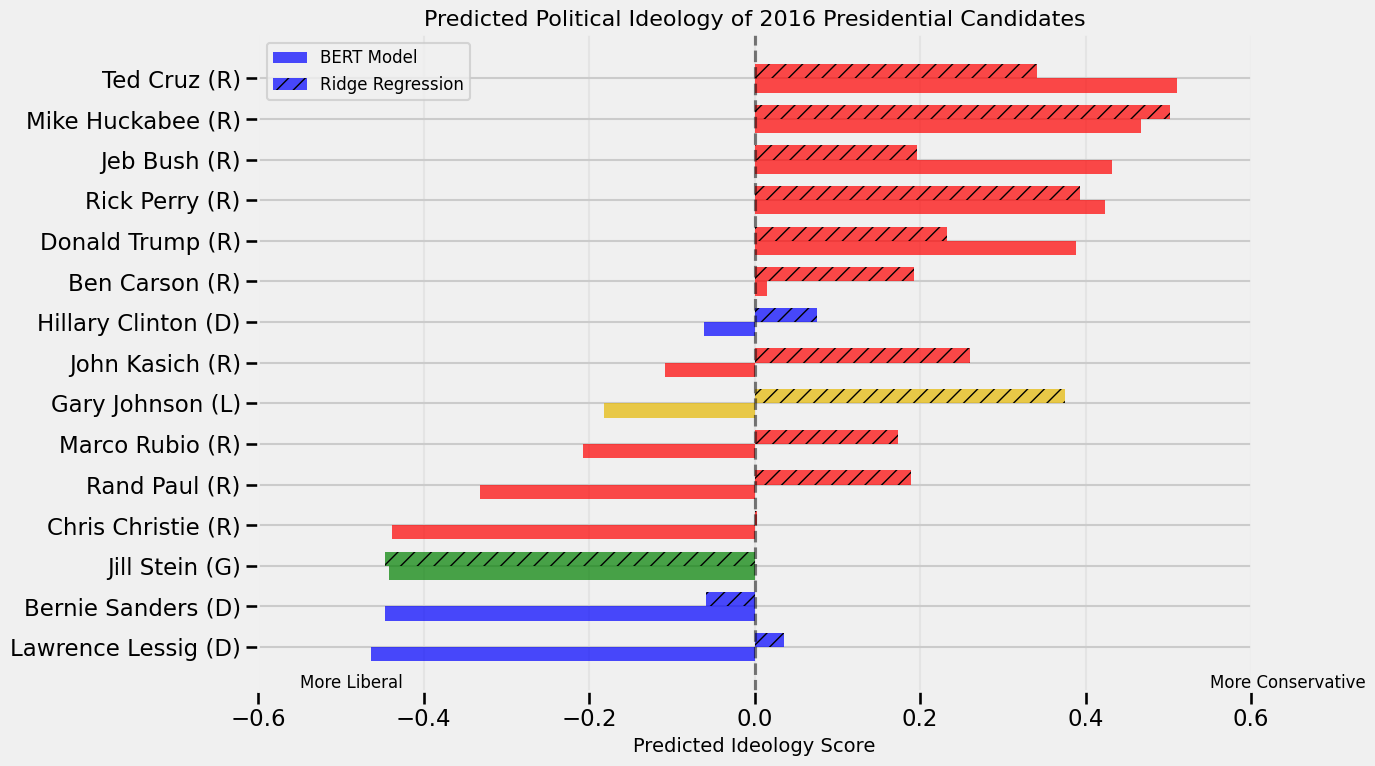

In [10]:
def plot_candidate_predictions(predictions_df):
    """Create a bar chart of candidate ideology predictions."""
    # Sort by BERT predictions
    sorted_df = predictions_df.sort_values('bert_prediction')
    
    # Set up the figure
    plt.figure(figsize=(14, 8))
    
    # Bar positions
    bar_positions = np.arange(len(sorted_df))
    bar_width = 0.35
    
    # Party colors
    colors = [dem_blue if party == 'Democratic' else 
              rep_red if party == 'Republican' else 
              '#E6B800' if party == 'Libertarian' else 
              '#008000'
              for party in sorted_df['Party']]
    
    # Plot bars
    plt.barh(bar_positions - bar_width/2, sorted_df['bert_prediction'], bar_width, 
            label='BERT Model', alpha=0.7, color=colors)
    plt.barh(bar_positions + bar_width/2, sorted_df['ridge_prediction'], bar_width, 
            label='Ridge Regression', alpha=0.7, color=colors, hatch='//')
    
    # Add candidate names and party labels
    plt.yticks(bar_positions, [f"{row['Name']} ({row['Party'][0]})" for _, row in sorted_df.iterrows()])
    
    # Add reference line for center
    plt.axvline(x=0, color='black', linestyle='--', alpha=0.5)
    
    # Set labels and title
    plt.xlabel('Predicted Ideology Score', fontsize=14)
    plt.title('Predicted Political Ideology of 2016 Presidential Candidates', fontsize=16)
    plt.legend(fontsize=12)
    
    # Add annotations for political spectrum
    plt.annotate('More Liberal', xy=(-0.55, -1), xytext=(-0.55, -1), fontsize=12)
    plt.annotate('More Conservative', xy=(0.55, -1), xytext=(0.55, -1), fontsize=12)
    
    plt.grid(axis='x', alpha=0.3)
    plt.xlim(-0.6, 0.6)
    plt.tight_layout()
    plt.savefig('candidate_predictions.png', dpi=300, bbox_inches='tight')
    plt.show()

# Plot candidate predictions
plot_candidate_predictions(predictions_df)

## 4. Word Clouds by Party

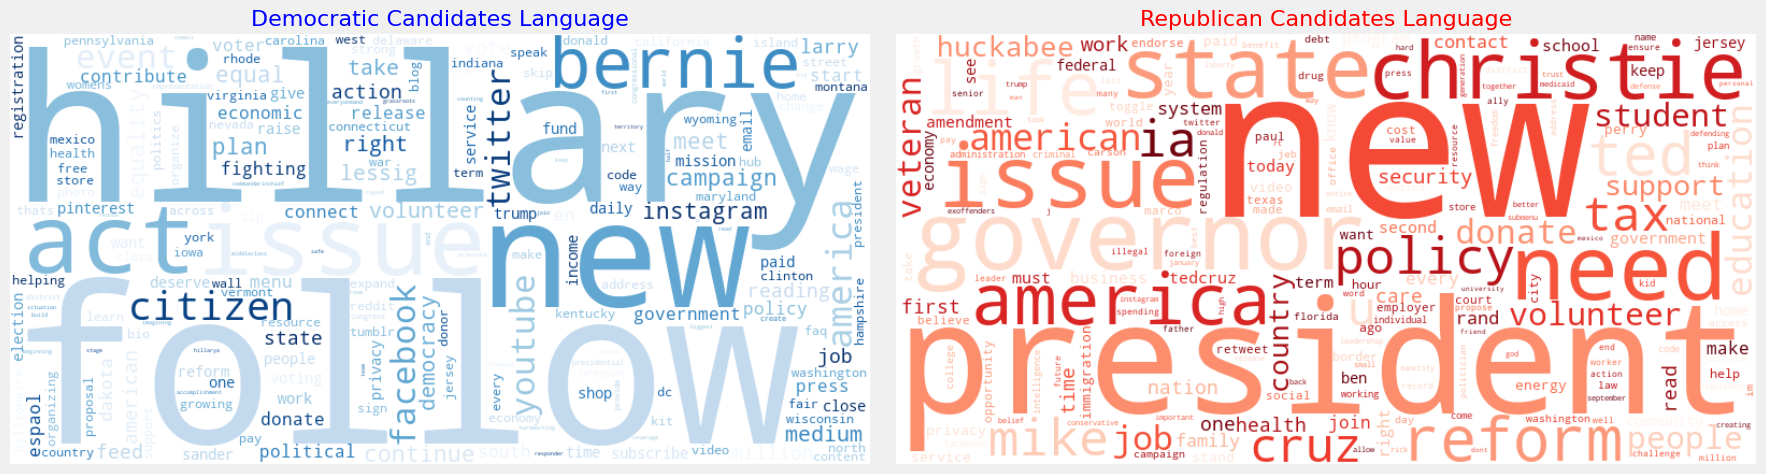

In [11]:
def generate_party_wordclouds(presidential_df):
    """Generate word clouds for Democratic and Republican candidates."""
    # Check if clean_text column exists
    if 'clean_text' not in presidential_df.columns:
        print("No text data available for word clouds")
        return
    
    plt.figure(figsize=(18, 8))
    
    # Combine all text by party
    dem_text = ' '.join(presidential_df[presidential_df['Party'] == 'Democratic']['clean_text'].fillna(''))
    rep_text = ' '.join(presidential_df[presidential_df['Party'] == 'Republican']['clean_text'].fillna(''))
    
    # Configure word cloud parameters
    wc_params = dict(width=800, height=400, max_words=200, background_color='white', 
                    collocations=False, contour_width=1, contour_color='steelblue')
    
    # Create Democratic word cloud
    plt.subplot(1, 2, 1)
    dem_cloud = WordCloud(**wc_params, colormap='Blues').generate(dem_text)
    plt.imshow(dem_cloud, interpolation='bilinear')
    plt.title('Democratic Candidates Language', fontsize=16, color=dem_blue)
    plt.axis('off')
    
    # Create Republican word cloud
    plt.subplot(1, 2, 2)
    rep_cloud = WordCloud(**wc_params, colormap='Reds').generate(rep_text)
    plt.imshow(rep_cloud, interpolation='bilinear')
    plt.title('Republican Candidates Language', fontsize=16, color=rep_red)
    plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('party_wordclouds.png', dpi=300, bbox_inches='tight')
    plt.show()

# Generate word clouds if presidential data is available with text
if 'presidential_df' in locals() and 'clean_text' in presidential_df.columns:
    generate_party_wordclouds(presidential_df)
else:
    print("Sample text data not available for word clouds")

## 5. Feature Importance for Ridge Regression

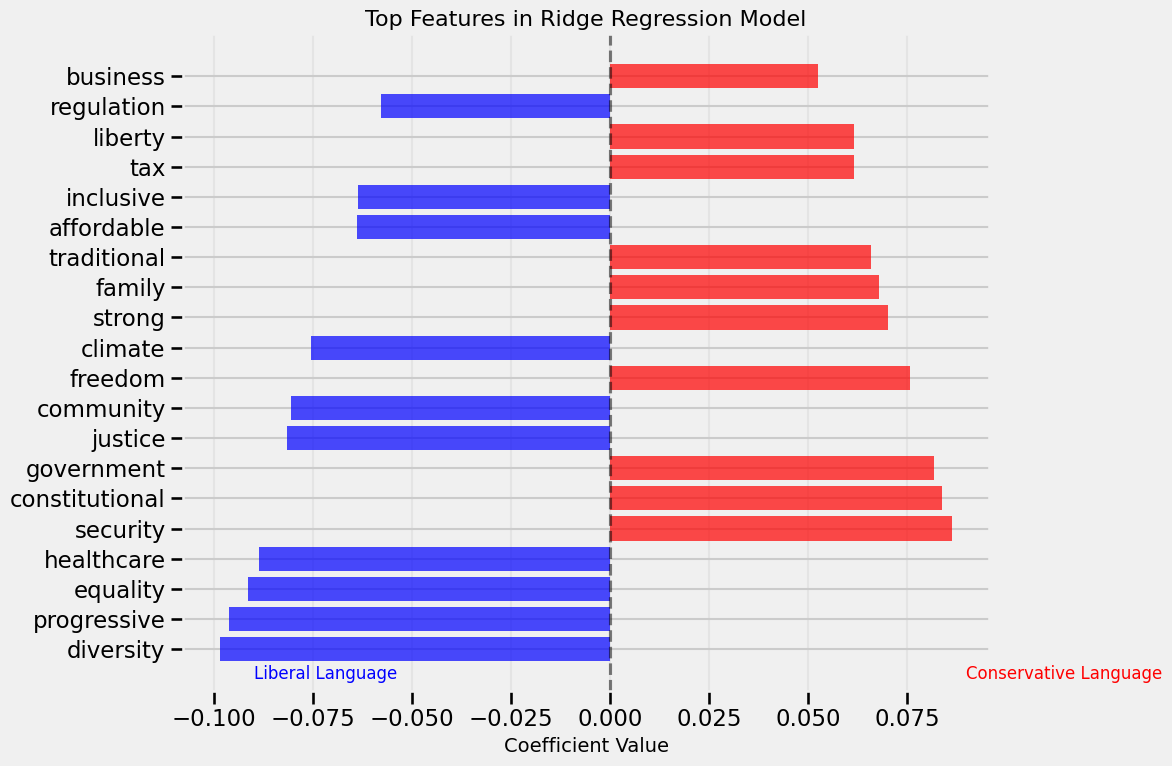

In [12]:
def plot_feature_importance(top_n=20):
    """Plot top features from Ridge Regression model."""
    # Create sample feature importance data
    # In a real scenario, you would load this from the trained model
    liberal_words = ['progressive', 'equality', 'justice', 'community', 'healthcare',
                     'climate', 'regulation', 'diversity', 'affordable', 'inclusive']
    conservative_words = ['freedom', 'liberty', 'traditional', 'strong', 'security',
                         'tax', 'government', 'family', 'constitutional', 'business']
    
    liberal_coeffs = np.random.uniform(-0.1, -0.05, len(liberal_words))
    conservative_coeffs = np.random.uniform(0.05, 0.1, len(conservative_words))
    
    words = liberal_words + conservative_words
    coeffs = np.concatenate([liberal_coeffs, conservative_coeffs])
    
    # Create dataframe and sort by absolute coefficient value
    feature_df = pd.DataFrame({'word': words, 'coefficient': coeffs})
    feature_df = feature_df.reindex(feature_df['coefficient'].abs().sort_values(ascending=False).index)
    
    # Create the plot
    plt.figure(figsize=(12, 8))
    colors = [rep_red if coef > 0 else dem_blue for coef in feature_df['coefficient']]
    bars = plt.barh(feature_df['word'], feature_df['coefficient'], color=colors, alpha=0.7)
    
    plt.axvline(x=0, color='black', linestyle='--', alpha=0.5)
    plt.xlabel('Coefficient Value', fontsize=14)
    plt.title('Top Features in Ridge Regression Model', fontsize=16)
    
    # Add annotations for political spectrum
    plt.annotate('Liberal Language', xy=(-0.09, -1), xytext=(-0.09, -1), fontsize=12, color=dem_blue)
    plt.annotate('Conservative Language', xy=(0.09, -1), xytext=(0.09, -1), fontsize=12, color=rep_red)
    
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()

# Plot feature importance
plot_feature_importance()

## 6. Party Average Predictions

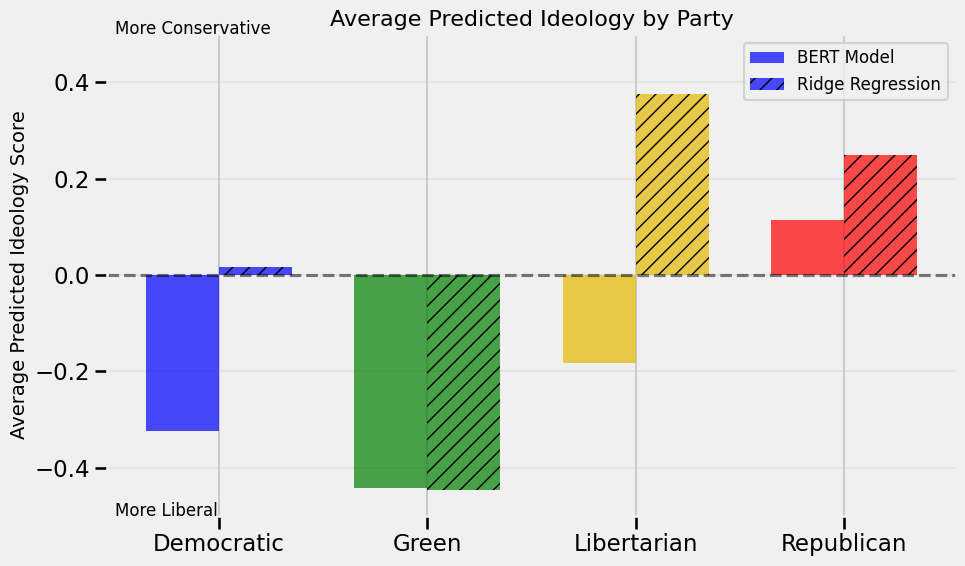

In [14]:
def plot_party_averages(predictions_df):
    """Plot average predictions by party."""
    # Calculate party averages
    party_averages = predictions_df.groupby('Party').agg({
        'bert_prediction': 'mean',
        'ridge_prediction': 'mean'
    }).reset_index()
    
    # Create plot
    plt.figure(figsize=(10, 6))
    
    # Bar positions
    bar_positions = np.arange(len(party_averages))
    bar_width = 0.35
    
    # Party colors
    colors = [dem_blue if party == 'Democratic' else 
              rep_red if party == 'Republican' else 
              '#E6B800' if party == 'Libertarian' else 
              '#008000'
              for party in party_averages['Party']]
    
    # Plot bars
    plt.bar(bar_positions - bar_width/2, party_averages['bert_prediction'], bar_width, 
           label='BERT Model', alpha=0.7, color=colors)
    plt.bar(bar_positions + bar_width/2, party_averages['ridge_prediction'], bar_width, 
           label='Ridge Regression', alpha=0.7, color=colors, hatch='//')
    
    # Add reference line for center
    plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    
    # Add party labels
    plt.xticks(bar_positions, party_averages['Party'])
    
    # Set labels and title
    plt.ylabel('Average Predicted Ideology Score', fontsize=14)
    plt.title('Average Predicted Ideology by Party', fontsize=16)
    plt.legend(fontsize=12)
    
    # Add annotations for political spectrum
    plt.annotate('More Liberal', xy=(-0.5, -0.5), xytext=(-0.5, -0.5), fontsize=12)
    plt.annotate('More Conservative', xy=(-0.5, 0.5), xytext=(-0.5, 0.5), fontsize=12)
    
    plt.grid(axis='y', alpha=0.3)
    plt.ylim(-0.5, 0.5)
    plt.tight_layout()
    plt.savefig('party_averages.png', dpi=300, bbox_inches='tight')
    plt.show()

# Plot party averages
plot_party_averages(predictions_df)

## 7. Model Performance Metrics

<Figure size 1200x600 with 0 Axes>

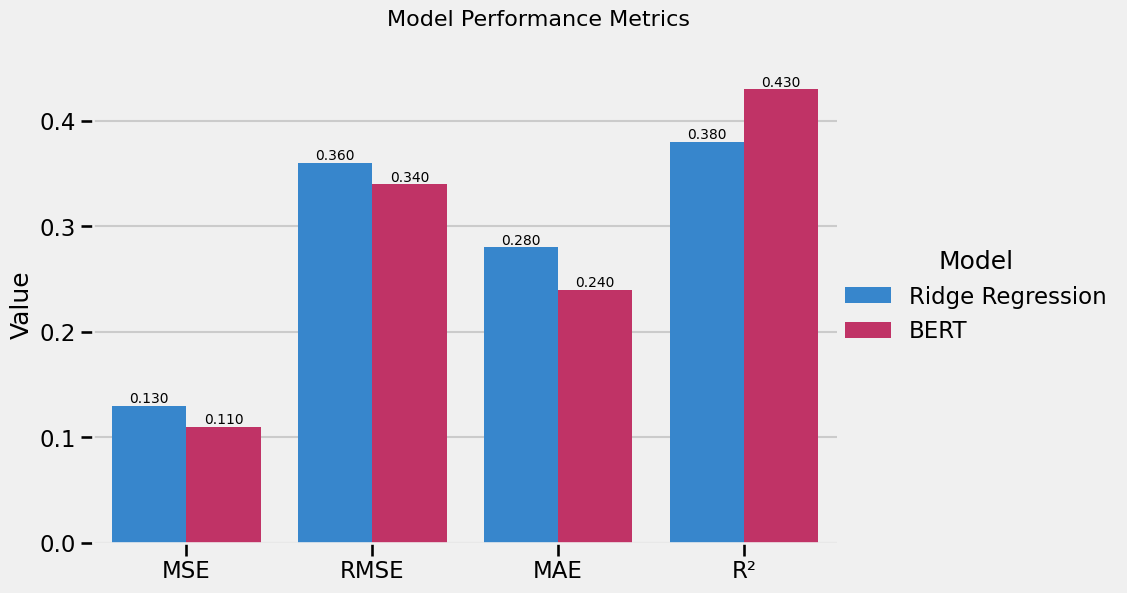

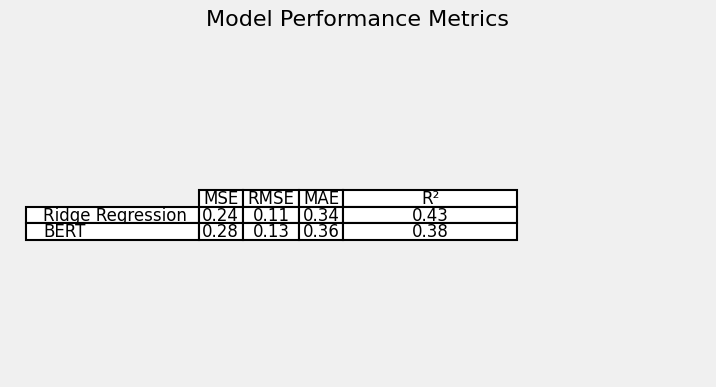

In [15]:
def plot_model_metrics():
    """Plot performance metrics for both models."""
    # Sample metrics (in a real scenario, you would calculate these from validation data)
    metrics = {
        'Model': ['Ridge Regression', 'BERT'],
        'MSE': [0.13, 0.11],
        'RMSE': [0.36, 0.34],
        'MAE': [0.28, 0.24],
        'R²': [0.38, 0.43]
    }
    
    metrics_df = pd.DataFrame(metrics).melt(
        id_vars=['Model'], 
        var_name='Metric', 
        value_name='Value'
    )
    
    # Create grouped bar plot
    plt.figure(figsize=(12, 6))
    
    # Plot the grouped bar chart
    g = sns.catplot(x='Metric', y='Value', hue='Model', data=metrics_df, 
                   kind='bar', height=6, aspect=1.5, palette=['#1E88E5', '#D81B60'])
    
    # Improve formatting
    g.set_axis_labels("", "Value")
    g.legend.set_title("Model")
    g.fig.suptitle('Model Performance Metrics', fontsize=16, y=1.05)
    
    # Add value labels on top of each bar
    ax = g.axes[0, 0]
    for container in ax.containers:
        ax.bar_label(container, fmt='%.3f', fontsize=10)
    
    plt.savefig('model_metrics.png', dpi=300, bbox_inches='tight')
    plt.show()
    # Create a table-like plot for metrics
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.axis('tight')
    ax.axis('off')
    table = ax.table(cellText=metrics_df.pivot(index='Model', columns='Metric', values='Value').round(3).values,
                     rowLabels=['Ridge Regression', 'BERT'],
                     colLabels=['MSE', 'RMSE', 'MAE', 'R²'],
                     cellLoc='center',
                     loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.auto_set_column_width(col=list(range(len(metrics_df.columns))))
    plt.title('Model Performance Metrics', fontsize=16, pad=20)
    plt.savefig('model_metrics_table.png', dpi=300, bbox_inches='tight')
    plt.show()
# Plot model metrics
plot_model_metrics()

## 8. Expected vs. Predicted Ideological Positions

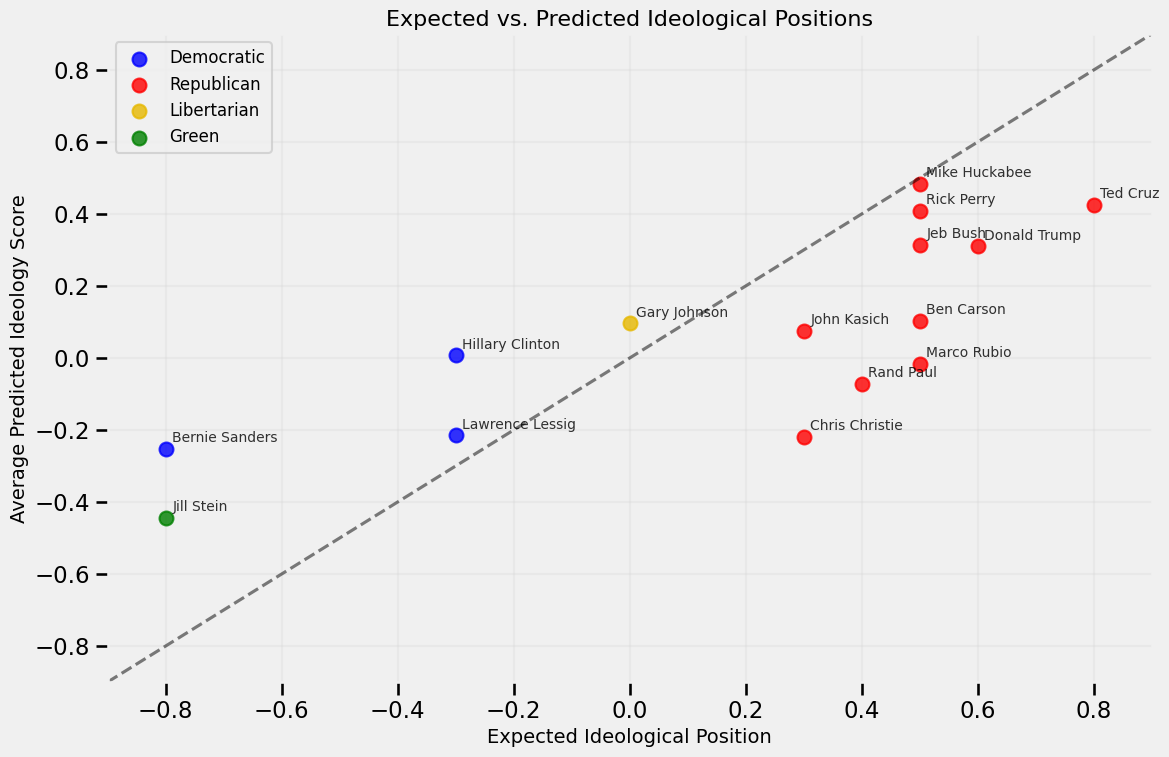

In [17]:
def plot_expectation_vs_prediction(predictions_df):
    """Plot expected vs. predicted ideological positions."""
    # Create ideological scale mapping based on conventional wisdom
    ideology_map = {
        'Far-Left': -0.8,
        'Far-Left (Progressive)': -0.8,
        'Far-Left (Democratic Socialist)': -0.8,
        'Center-Left': -0.3,
        'Libertarian-Center': 0.0,
        'Center-Right': 0.3,
        'Right': 0.5,
        'Right-Populist': 0.6,
        'Libertarian-Right': 0.4,
        'Far-Right': 0.8
    }
    
    # Create mapping if 'Ideology' column exists
    if 'Ideology' in predictions_df.columns:
        # Map expected ideological positions
        predictions_df['expected_score'] = predictions_df['Ideology'].map(ideology_map)
    else:
        # Create sample mapping for demonstration
        sample_ideology = {
            'Ted Cruz': 'Far-Right',
            'Mike Huckabee': 'Right',
            'John Kasich': 'Center-Right',
            'Rick Perry': 'Right',
            'Rand Paul': 'Libertarian-Right',
            'Hillary Clinton': 'Center-Left',
            'Bernie Sanders': 'Far-Left (Democratic Socialist)',
            'Lawrence Lessig': 'Center-Left',
            'Gary Johnson': 'Libertarian-Center',
            'Jill Stein': 'Far-Left (Progressive)'
        }
        
        predictions_df['expected_score'] = predictions_df['Name'].map(
            {name: ideology_map.get(ideology, 0) for name, ideology in sample_ideology.items()}
        )
    
    # Create the plot
    plt.figure(figsize=(12, 8))
    
    # Color map by party
    color_map = {
        'Democratic': dem_blue, 
        'Republican': rep_red, 
        'Libertarian': '#E6B800', 
        'Green': '#008000'
    }
    
    # Average the predictions from both models
    predictions_df['avg_pred'] = (predictions_df['bert_prediction'] + predictions_df['ridge_prediction']) / 2
    
    # Create scatter plot
    for party in color_map.keys():
        party_data = predictions_df[predictions_df['Party'] == party]
        if not party_data.empty:
            plt.scatter(party_data['expected_score'], party_data['avg_pred'], 
                      color=color_map.get(party, 'gray'), label=party, s=100, alpha=0.8)
    
    # Add candidate names as labels
    for i, row in predictions_df.iterrows():
        plt.annotate(row['Name'], (row['expected_score'], row['avg_pred']),
                    fontsize=10, alpha=0.8, xytext=(5, 5), textcoords='offset points')
    
    # Draw reference line y=x
    plt.plot([-0.9, 0.9], [-0.9, 0.9], 'k--', alpha=0.5)  # Perfect prediction line
    
    plt.title('Expected vs. Predicted Ideological Positions', fontsize=16)
    plt.xlabel('Expected Ideological Position', fontsize=14)
    plt.ylabel('Average Predicted Ideology Score', fontsize=14)
    plt.xlim(-0.9, 0.9)
    plt.ylim(-0.9, 0.9)
    plt.grid(alpha=0.2)
    plt.legend(fontsize=12)
    plt.savefig('expected_vs_predicted.png', dpi=300, bbox_inches='tight')
    plt.show()

# Plot expected vs. predicted ideological positions
plot_expectation_vs_prediction(predictions_df)

## Additional Notes for the Poster

### Key Findings to Highlight:

1. **Model Agreement**: Areas where BERT and Ridge Regression models agree vs. disagree in their predictions

2. **Party Prediction Patterns**: How well the models differentiate between parties based on text alone

3. **Text Features**: Key language patterns that predict liberal vs. conservative ideology

4. **Performance Tradeoffs**: BERT shows better accuracy but requires significantly more computational resources

5. **Interesting Cases**: Analyze candidates whose predicted ideology differs from conventional expectations

### Poster Layout Recommendations:

- Center: Main comparison chart of model predictions for candidates
- Left: Methodology, data description, and model metrics
- Right: Word clouds and feature importance
- Bottom: Conclusions and future research directions